In [1]:
import numpy as np
from os import listdir
from os.path import isfile, join
import tifffile
from cellpose import models, io, core
import time
from sklearn.model_selection import train_test_split
from statistics import mean
from u_net import UNet
import torch
from skimage import measure

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_files(path,normalise=False,remove_txt=False):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    if remove_txt:
        onlyfiles = [val for val in onlyfiles if not val.endswith(".txt")]

    onlyfiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #if num_imgs > len(onlyfiles): num_imgs = len(onlyfiles)
    files = [np.squeeze(tifffile.imread(path +  onlyfiles[i])) for i in range(len(onlyfiles))]
    
    if normalise:
        files = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in files]
    
    return files
    
def get_data(path, set='01',normalise_images=True):

    if len(set) == 2: #set 01 or set 02
        images_path = path + set + '/'
        images = get_files(images_path,normalise=normalise_images)
        masks_path = path + set + '_GT/TRA/'
        masks = get_files(masks_path,remove_txt=True)
    elif set == '0102': #both sets
        images_path = path + '01/'
        images_01 = get_files(images_path,normalise=normalise_images)
        images_path = path + '02/'
        images_02 = get_files(images_path,normalise=normalise_images)
        images = images_01 + images_02

        masks_path = path + '01_GT/TRA/'
        masks_01 = get_files(masks_path,remove_txt=True)
        masks_path = path + '02_GT/TRA/'
        masks_02 = get_files(masks_path,remove_txt=True)
        masks = masks_01 + masks_02
    else:
        images = []
        masks = []

    return images, masks

In [3]:
def get_IoU(predicted_masks,gt_masks, return_list=False):
    intersection_unions = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        union = np.logical_or(predicted_masks[i], gt_masks[i]).sum()
        intersection_unions.append(intersection/union)
    if return_list:
        return intersection_unions
    return mean(intersection_unions)

def get_dice(predicted_masks,gt_masks, return_list=False):
    dices = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        dice = (2*intersection)/(predicted_masks[i].sum() + gt_masks[i].sum())
        dices.append(dice)
    if return_list:
        return dices
    return mean(dices)

In [4]:
#images_02, masks_02 = get_data("/Users/rehanzuberi/Downloads/distillCellSegTrack/" + 'datasets/Fluo-N2DL-HeLa/', num_imgs=92, set='01')
#images_02, masks_02 = get_data("\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\" + 'datasets/Fluo-N2DL-HeLa/', num_imgs=92, set='01')
images, masks = get_data("\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\" + 'datasets/Fluo-N2DH-SIM+/', set='0102')

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

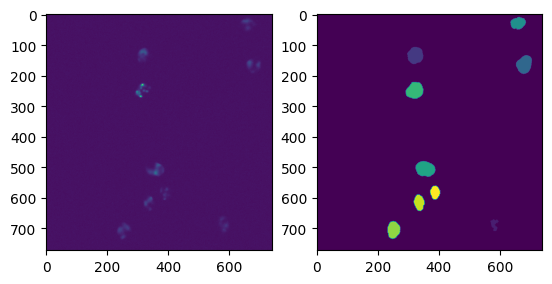

In [5]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.imshow(images_train[1])
plt.subplot(1,2,2)
plt.imshow(masks_train[1])


In [6]:
for i in range(len(images_train)):
    print(masks_train[i].shape)

(773, 739)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(690, 628)
(690, 628)
(773, 739)
(773, 739)
(690, 628)
(690, 628)
(773, 739)
(773, 739)
(690, 628)
(773, 739)
(690, 628)
(773, 739)
(690, 628)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(690, 628)
(690, 628)
(690, 628)
(690, 628)
(690, 628)
(773, 739)
(773, 739)
(773, 739)
(690, 628)
(773, 739)
(773, 739)
(773, 739)
(690, 628)
(773, 739)
(773, 739)
(773, 739)
(690, 628)
(773, 739)
(773, 739)
(773, 739)
(690, 628)
(773, 739)
(690, 628)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(690, 628)
(773, 739)
(690, 628)
(690, 628)
(773, 739)
(773, 739)
(690, 628)
(690, 628)
(773, 739)
(773, 739)
(690, 628)
(690, 628)
(773, 739)
(773, 739)
(773, 739)
(690, 628)
(690, 628)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(690, 628)
(690, 628)
(773, 739)
(773, 739)
(773, 739)
(690, 628)
(773, 739)
(773, 739)
(773, 739)
(773, 739)
(690, 628)
(690, 628)
(773, 739)
(690, 628)

In [7]:
#Get cellpose predictions and the distilled U-Net predictions
#cellpose_model = models.CellposeModel(gpu=core.use_gpu(), pretrained_model='/Users/rehanzuberi/Downloads/distillCellSegTrack/segmentation/train_dir/models/cellpose_trained_model')
cellpose_model = models.CellposeModel(gpu=core.use_gpu(), pretrained_model='/Users/rz200/Documents/development/distillCellSegTrack/segmentation/train_dir/models/cellpose_trained_model_GOWT1_2')
print(cellpose_model.diam_labels)
cellpose_predicted_masks = cellpose_model.eval(images_test, batch_size=1, channels=[0,0], diameter=cellpose_model.diam_labels)[0]

45.370316


KeyboardInterrupt: 

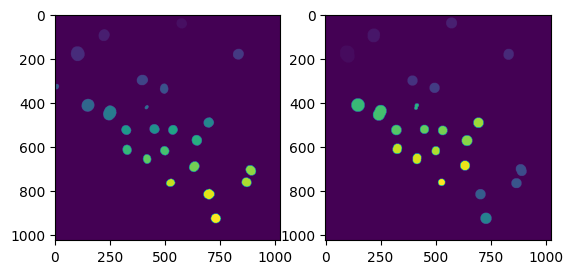

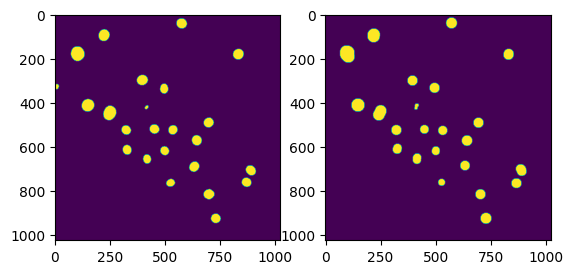

In [6]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.imshow(cellpose_predicted_masks[0])
plt.subplot(1,2,2)
plt.imshow(masks_test[0])
plt.show()

bin_pred = np.where(cellpose_predicted_masks[0] > 0, 1, 0)
bin_mask = np.where(masks_test[0] > 0, 1, 0)
plt.subplot(1,2,1)
plt.imshow(bin_pred)
plt.subplot(1,2,2)
plt.imshow(bin_mask)
plt.show()

In [66]:
#Get base cellpose 'cyto' predictions
cellpose_cyto_model = models.Cellpose(gpu=core.use_gpu(),model_type='cyto',device=torch.device('cuda:0'))
cellpose_cyto_predicted_masks = cellpose_cyto_model.eval(images_test, batch_size=1, channels=[0,0])[0]

In [22]:
#Get distilled U-Net predictions

def split_image(img):
    sub_images = []
    for i in range(0, 1024, 256):
        for j in range(0, 1024, 256):
            sub_img = img[i:i+256, j:j+256]
            sub_images.append(sub_img)
            
    return sub_images

def combine_images(sub_images):
    img = np.zeros((1024, 1024))
    k = 0
    for i in range(0, 1024, 256):
        for j in range(0, 1024, 256):
            img[i:i+256, j:j+256] = sub_images[k]
            k += 1
    return img

model = UNet()
model = model.to('cuda:0')
#model.load_state_dict(torch.load('/Users/rehanzuberi/Downloads/distillCellSegTrack/segmentation/train_dir/models/unet_trained_model',map_location=torch.device('cpu')))
model.load_state_dict(torch.load('/Users/rz200/Documents/development/distillCellSegTrack/segmentation/train_dir/models/distillation_model_GOWT1_4'))
distilled_predicted_masks = []
for test_image in images_test:
    test_image = torch.from_numpy(test_image).float().unsqueeze(0).unsqueeze(0).to('cuda:0')
    test_image_split = split_image(test_image.cpu().detach().numpy().squeeze(0).squeeze(0))
    distilled_predicted_sub_masks = []
    for sub_image in test_image_split:
        sub_image = torch.from_numpy(sub_image).float().unsqueeze(0).unsqueeze(0).to('cuda:0')
        distilled_predicted_sub_mask = model(sub_image).squeeze(0).squeeze(0).cpu().detach().numpy()
        distilled_predicted_sub_mask = 1/(1+np.exp(-distilled_predicted_sub_mask))
        distilled_predicted_sub_mask = np.where(distilled_predicted_sub_mask > 0.4, 1, 0)
        distilled_predicted_sub_masks.append(distilled_predicted_sub_mask)
    distilled_predicted_mask = combine_images(distilled_predicted_sub_masks)
    distilled_predicted_masks.append(distilled_predicted_mask)

    #test_image = torch.from_numpy(test_image).float().unsqueeze(0).unsqueeze(0)
    #outputs = model(test_image).squeeze(0).squeeze(0).cpu().detach().numpy()
    #outputs = 1/(1+np.exp(-outputs)) #sigmoid the outputs
    #binary_outputs = np.where(outputs > 0.5, 1, 0)
    #predicted_instance_mask = measure.label(predicted_binary_mask, connectivity=2)
    #distilled_predicted_masks.append(binary_outputs)

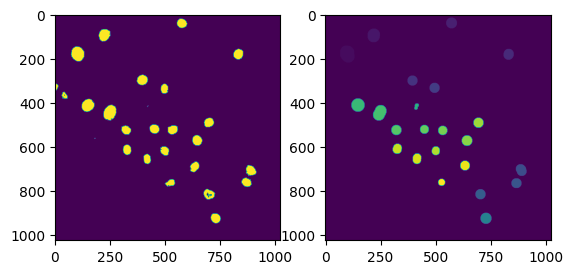

In [23]:
plt.subplot(1,2,1)
plt.imshow(distilled_predicted_masks[0])
plt.subplot(1,2,2)
plt.imshow(masks_test[0])
plt.show()

In [24]:
#Binarise the ground truth masks
masks_02_test_binary = [np.where(mask>0,1,0) for mask in masks_test]

#Binarise the cellpose predictions
cellpose_predicted_masks_binary = [np.where(mask>0,1,0) for mask in cellpose_predicted_masks]
cellpose_cyto_predicted_masks_binary = [np.where(mask>0,1,0) for mask in cellpose_cyto_predicted_masks]

NameError: name 'cellpose_cyto_predicted_masks' is not defined

In [25]:
#Get IoU and dice coeff between cellpose trained and groundtruth
print("IoU between cellpose trained and groundtruth: ", get_IoU(cellpose_predicted_masks_binary, masks_02_test_binary))
print("Dice coeff between cellpose trained and groundtruth: ", get_dice(cellpose_predicted_masks_binary, masks_02_test_binary))

#Get IoU and dice coeff between cellpose 'cyto' and groundtruth
#print("IoU between cellpose 'cyto' and groundtruth: ", get_IoU(cellpose_cyto_predicted_masks_binary, masks_02_test_binary))
#print("Dice coeff between cellpose 'cyto' and groundtruth: ", get_dice(cellpose_cyto_predicted_masks_binary, masks_02_test_binary))

#Get IoU and dice coeff between distilled U-Net and groundtruth
print("IoU between distilled U-Net and groundtruth: ", get_IoU(distilled_predicted_masks, masks_02_test_binary))
print("Dice coeff between distilled U-Net and groundtruth: ", get_dice(distilled_predicted_masks, masks_02_test_binary))

IoU between cellpose trained and groundtruth:  0.7971204504785732
Dice coeff between cellpose trained and groundtruth:  0.8870573172307469
IoU between distilled U-Net and groundtruth:  0.7601435186409872
Dice coeff between distilled U-Net and groundtruth:  0.8636033775778466


       result metric               model
0    0.798208    IoU    cellpose_trained
1    0.799902    IoU    cellpose_trained
2    0.797904    IoU    cellpose_trained
3    0.813369    IoU    cellpose_trained
4    0.783229    IoU    cellpose_trained
..        ...    ...                 ...
143  0.856722   Dice  distilled_cellpose
144  0.891029   Dice  distilled_cellpose
145  0.873252   Dice  distilled_cellpose
146  0.822013   Dice  distilled_cellpose
147  0.854494   Dice  distilled_cellpose

[148 rows x 3 columns]


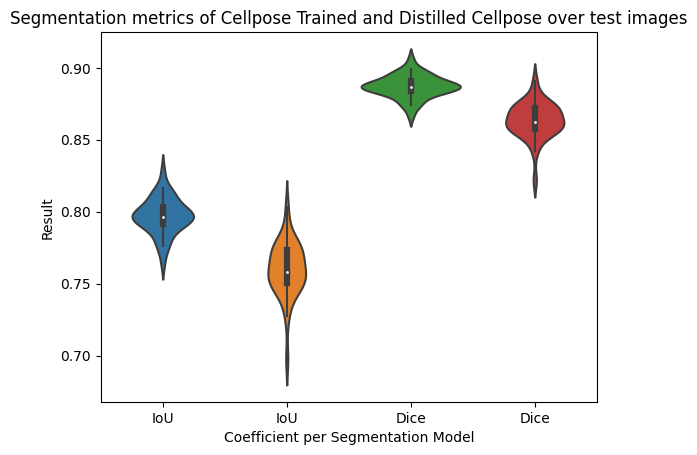

In [27]:
import seaborn as sns
import pandas as pd

cellpose_trained_IoU_results = get_IoU(cellpose_predicted_masks_binary, masks_02_test_binary, return_list=True)
distilled_cellpose_IoU_results = get_IoU(distilled_predicted_masks, masks_02_test_binary, return_list=True)

cellpose_trained_dice_results = get_dice(cellpose_predicted_masks_binary, masks_02_test_binary, return_list=True)
distilled_cellpose_dice_results = get_dice(distilled_predicted_masks, masks_02_test_binary, return_list=True)

#create a dataframe with the results where each column is a different coefficient
df = pd.DataFrame({'result': cellpose_trained_IoU_results+cellpose_trained_dice_results+distilled_cellpose_IoU_results+distilled_cellpose_dice_results, 'metric': ['IoU']*len(cellpose_trained_IoU_results)+['Dice']*len(cellpose_trained_dice_results)+['IoU']*len(distilled_cellpose_IoU_results)+['Dice']*len(distilled_cellpose_dice_results), 'model': ['cellpose_trained']*len(cellpose_trained_IoU_results)*2+['distilled_cellpose']*len(distilled_cellpose_IoU_results)*2})
print(df)
#df_long = pd.melt(df, "model", "metric", "result")


fig, ax = plt.subplots()
sns.violinplot([cellpose_trained_IoU_results,distilled_cellpose_IoU_results,cellpose_trained_dice_results,distilled_cellpose_dice_results], ax=ax)
#ax.set_ylim(0, 1)
ax.set_title('Segmentation metrics of Cellpose Trained and Distilled Cellpose over test images')
ax.set_ylabel('Result')
ax.set_xlabel('Coefficient per Segmentation Model')
ax.set_xticklabels(['IoU', 'IoU','Dice','Dice'])
plt.show()

In [50]:
#IOU

#Cellpose trained
print(round(min(cellpose_trained_IoU_results)*100,1))
print(round(mean(cellpose_trained_IoU_results)*100,1))
print(round(max(cellpose_trained_IoU_results)*100,1))
print('\n')
#Distilled Cellpose
print(round(min(distilled_cellpose_IoU_results)*100,1))
print(round(mean(distilled_cellpose_IoU_results)*100,1))
print(round(max(distilled_cellpose_IoU_results)*100,1))

76.5
79.7
82.8


69.8
76.0
80.3


In [53]:
#DICE

#Cellpose trained
print(round(min(cellpose_trained_dice_results)*100,1))
print(round(mean(cellpose_trained_dice_results)*100,1))
print(round(max(cellpose_trained_dice_results)*100,1))
print('\n')
#Distilled Cellpose
print(round(min(distilled_cellpose_dice_results)*100,1))
print(round(mean(distilled_cellpose_dice_results)*100,1))
print(round(max(distilled_cellpose_dice_results)*100,1))

86.7
88.7
90.6


82.2
86.4
89.1


In [30]:
distilled_predicted_masks_instances = []
for image in distilled_predicted_masks:
    distilled_predicted_masks_instances.append(measure.label(image, connectivity=2))

In [8]:
#make crops of 256x256 of the test images with random coordinates, then plot the test image crop, the mask crop, the cellpose prediction crop and the distilled prediction crop
import random
import matplotlib.pyplot as plt
import numpy as np

images = []
masks = []
cellpose_predictions = []
distilled_predictions = []

for i in range(10):
    random_x = random.randint(0, 512-256)
    random_y = random.randint(0, 512-256)
    random_image_crop = images_test[i][random_x:random_x+256, random_y:random_y+256]
    random_mask_crop = masks_test[i][random_x:random_x+256, random_y:random_y+256]
    random_cellpose_prediction_crop = cellpose_predicted_masks[i][random_x:random_x+256, random_y:random_y+256]
    random_distilled_prediction_crop = distilled_predicted_masks_instances[i][random_x:random_x+256, random_y:random_y+256]

    #get the proportion of non-zero pixels in the mask crop
    mask_proportion = np.count_nonzero(random_mask_crop)/(256*256)
    #if the proportion of non-zero pixels in the mask crop is less than 0.1, then get a new random crop
    while mask_proportion < 0.1:
        random_x = random.randint(0, 512-256)
        random_y = random.randint(0, 512-256)
        random_image_crop = images_test[i][random_x:random_x+256, random_y:random_y+256]
        random_mask_crop = masks_test[i][random_x:random_x+256, random_y:random_y+256]
        random_cellpose_prediction_crop = cellpose_predicted_masks[i][random_x:random_x+256, random_y:random_y+256]
        random_distilled_prediction_crop = distilled_predicted_masks_instances[i][random_x:random_x+256, random_y:random_y+256]
        mask_proportion = np.count_nonzero(random_mask_crop)/(256*256)
    
    #binarise every mask crop and put them through the measure.label function to get the instances
    random_mask_crop = measure.label(random_mask_crop > 0, connectivity=2)
    random_cellpose_prediction_crop = measure.label(random_cellpose_prediction_crop > 0, connectivity=2)
    random_distilled_prediction_crop = measure.label(random_distilled_prediction_crop > 0, connectivity=2)



    images.append(random_image_crop)
    masks.append(random_mask_crop)
    cellpose_predictions.append(random_cellpose_prediction_crop)
    distilled_predictions.append(random_distilled_prediction_crop)

    print(i)

#make the first row the test images, second row the masks, third row the cellpose predictions and fourth row the distilled predictions
images = np.array(images)
masks = np.array(masks)
cellpose_predictions = np.array(cellpose_predictions)
distilled_predictions = np.array(distilled_predictions)

#plot the images
fig, ax = plt.subplots(4,10, figsize=(20,10))
for i in range(10):
    ax[0,i].imshow(images[i])
    ax[1,i].imshow(masks[i])
    ax[2,i].imshow(cellpose_predictions[i])
    ax[3,i].imshow(distilled_predictions[i])
    #ax[0,i].set_title('Test image')
    #ax[1,i].set_title('Mask')
    #ax[2,i].set_title('Cellpose prediction')
    #ax[3,i].set_title('Distilled prediction')
    ax[0,i].axis('off')
    ax[1,i].axis('off')
    ax[2,i].axis('off')
    ax[3,i].axis('off')
plt.subplots_adjust(top = 0.6, bottom=0, hspace=0, wspace=0.2)
plt.show()



NameError: name 'cellpose_predicted_masks' is not defined

       Result      Metric               Model
0    0.798208         IoU    Cellpose Trained
1    0.799902         IoU    Cellpose Trained
2    0.797904         IoU    Cellpose Trained
3    0.813369         IoU    Cellpose Trained
4    0.783229         IoU    Cellpose Trained
..        ...         ...                 ...
143  0.845223  Dice score  Distilled Cellpose
144  0.841072  Dice score  Distilled Cellpose
145  0.871214  Dice score  Distilled Cellpose
146  0.844159  Dice score  Distilled Cellpose
147  0.833029  Dice score  Distilled Cellpose

[148 rows x 3 columns]


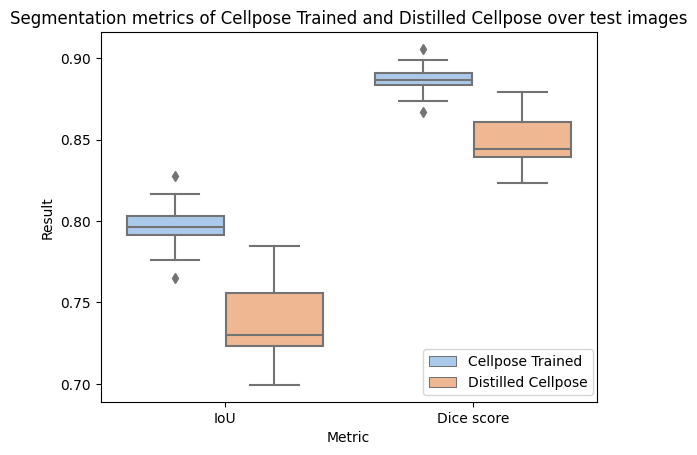

In [165]:
#I would add more faded colors to these

df = pd.DataFrame({'Result': cellpose_trained_IoU_results+cellpose_trained_dice_results+distilled_cellpose_IoU_results+distilled_cellpose_dice_results, 'Metric': ['IoU']*len(cellpose_trained_IoU_results)+['Dice score']*len(cellpose_trained_dice_results)+['IoU']*len(distilled_cellpose_IoU_results)+['Dice score']*len(distilled_cellpose_dice_results), 'Model': ['Cellpose Trained']*len(cellpose_trained_IoU_results)*2+['Distilled Cellpose']*len(distilled_cellpose_IoU_results)*2})
print(df)

plt.title('Segmentation metrics of Cellpose Trained and Distilled Cellpose over test images')
sns.boxplot(x="Metric", hue="Model", y="Result", data=df, palette="pastel")
#plt.legend(loc=(1.05, 0.876))
plt.legend(loc=(0.65, 0.0176))

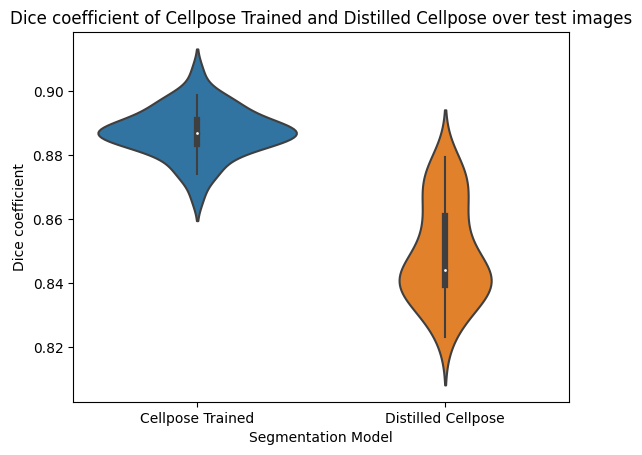

In [114]:
cellpose_trained_dice_results = get_dice(cellpose_predicted_masks_binary, masks_02_test_binary, return_list=True)
distilled_cellpose_dice_results = get_dice(distilled_predicted_masks, masks_02_test_binary, return_list=True)

fig, ax = plt.subplots()
sns.violinplot([cellpose_trained_dice_results,distilled_cellpose_dice_results], ax=ax)
#ax.set_ylim(0, 1)
ax.set_title('Dice coefficient of Cellpose Trained and Distilled Cellpose over test images')
ax.set_ylabel('Dice coefficient')
ax.set_xlabel('Segmentation Model')
ax.set_xticklabels(['Cellpose Trained', 'Distilled Cellpose'])
plt.show()

In [89]:
#Get IoU and dice coeff between cellpose trained and cellpose 'cyto' predictions
print("IoU between cellpose trained and cellpose 'cyto' predictions: ", get_IoU(cellpose_predicted_masks_binary, cellpose_cyto_predicted_masks_binary))
print("Dice coeff between cellpose trained and cellpose 'cyto' predictions: ", get_dice(cellpose_predicted_masks_binary, cellpose_cyto_predicted_masks_binary))

IoU between cellpose trained and cellpose 'cyto' predictions:  0.4430755732605966
Dice coeff between cellpose trained and cellpose 'cyto' predictions:  0.6120528867306952


In [90]:
#These are the distillation results
#Get IoU and dice coeff between distilled U-Net and groundtruth
print("IoU between distilled U-Net and cellpose trained: ", get_IoU(distilled_predicted_masks, cellpose_predicted_masks_binary))
print("Dice coeff between distilled U-Net and cellpose trained: ", get_dice(distilled_predicted_masks, cellpose_predicted_masks_binary))

print("IoU between distilled U-Net and cellpose 'cyto': ", get_IoU(distilled_predicted_masks, cellpose_cyto_predicted_masks_binary))
print("Dice coeff between distilled U-Net and cellpose 'cyto': ", get_dice(distilled_predicted_masks, cellpose_cyto_predicted_masks_binary))

IoU between distilled U-Net and cellpose trained:  0.8230565904030293
Dice coeff between distilled U-Net and cellpose trained:  0.9021909407770718
IoU between distilled U-Net and cellpose 'cyto':  0.4699824971201923
Dice coeff between distilled U-Net and cellpose 'cyto':  0.6388741761612708
